In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
weather = pd.read_csv("C:/Users/MUZAM/Downloads/weatherdata.csv", index_col="Date")
weather.columns = weather.columns.str.lower()
weather = weather.ffill()
weather

,tavg,tmax,tmin,prcp
Date,,,,
01-01-1980,75,NaN,68.0,0.00
02-01-1980,74,84.0,66.0,0.00
03-01-1980,76,84.0,66.0,0.00
04-01-1980,76,86.0,68.0,0.00
05-01-1980,77,84.0,70.0,0.00
...,...,...,...,...
28-06-2023,90,96.0,82.0,0.00
29-06-2023,88,99.0,82.0,0.00
30-06-2023,89,100.0,80.0,0.04


In [3]:
weather = weather.ffill()
weather.index = pd.to_datetime(weather.index)
weather.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2023-06-23', '2023-06-24', '2023-06-25', '2023-06-26',
               '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
               '2023-01-07', '2023-02-07'],
              dtype='datetime64[ns]', name='Date', length=15832, freq=None)

In [5]:
weather["target"]=weather.shift(-1)["tmin"]
weather

,tavg,tmax,tmin,prcp,target
Date,,,,,
1980-01-01,75,NaN,68.0,0.00,66.0
1980-02-01,74,84.0,66.0,0.00,66.0
1980-03-01,76,84.0,66.0,0.00,68.0
1980-04-01,76,86.0,68.0,0.00,70.0
1980-05-01,77,84.0,70.0,0.00,72.0
...,...,...,...,...,...
2023-06-28,90,96.0,82.0,0.00,82.0
2023-06-29,88,99.0,82.0,0.00,80.0
2023-06-30,89,100.0,80.0,0.04,82.0


In [6]:
weather = weather.fillna(weather.mean())
weather

,tavg,tmax,tmin,prcp,target
Date,,,,,
1980-01-01,75,92.700335,68.0,0.00,66.000000
1980-02-01,74,84.000000,66.0,0.00,66.000000
1980-03-01,76,84.000000,66.0,0.00,68.000000
1980-04-01,76,86.000000,68.0,0.00,70.000000
1980-05-01,77,84.000000,70.0,0.00,72.000000
...,...,...,...,...,...
2023-06-28,90,96.000000,82.0,0.00,82.000000
2023-06-29,88,99.000000,82.0,0.00,80.000000
2023-06-30,89,100.000000,80.0,0.04,82.000000


In [8]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
predictors = weather.columns[~weather.columns.isin(["target"])]
model.fit(weather[predictors], weather["target"])
latest_data = weather.iloc[-1:, :]
prediction = model.predict(latest_data[predictors])
print("Tomorrow's Minimum temperature(in Fahrenheit) prediction:", prediction)

Tomorrow's Minimum temperature(in Fahrenheit) prediction: [78.82787655]


In [9]:
r2 = model.score(weather[predictors], weather["target"])
print("R-squared:", r2)

R-squared: 0.9170195709078988


In [12]:
from sklearn.ensemble import RandomForestRegressor
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]
        model.fit(train[predictors], train["target"])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        all_predictions.append(combined)
    return pd.concat(all_predictions)
model = RandomForestRegressor()
predictors = weather.columns[~weather.columns.isin(["target"])]
predictions = backtest(weather, model, predictors)
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(predictions["actual"], predictions["prediction"])
mse = mean_squared_error(predictions["actual"], predictions["prediction"])
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)


Mean Absolute Error: 1.3757391325506254
Mean Squared Error: 3.7130002677370846


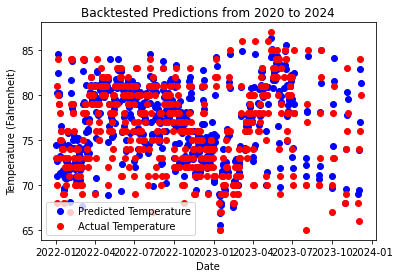

In [13]:
import matplotlib.pyplot as plt

# Filter the predictions for the desired date range
start_date = '2022-01-01'
end_date = '2024-12-31'
filtered_predictions = predictions.loc[(predictions.index >= start_date) & (predictions.index <= end_date)]

# Create a scatter plot
plt.scatter(filtered_predictions.index, filtered_predictions["prediction"], color='blue', label='Predicted Temperature')
plt.scatter(filtered_predictions.index, filtered_predictions["actual"], color='red', label='Actual Temperature')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Temperature (Fahrenheit)')
plt.title('Backtested Predictions from 2020 to 2024')

# Show the legend
plt.legend()

# Display the scatter plot
plt.show()
